In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from mini_yolov1.model import YOLO
from mini_yolov1.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov1.dataset import OxfordIIITPetDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov1.loss import YOLOLoss, build_target
import matplotlib.pyplot as plt
from mini_yolov1.utils import draw_bounding_boxes, count_model_parameters, draw_grid
from torchvision.ops import box_convert
from mini_yolov1.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm
from torchvision.transforms import v2

In [21]:
train_dataset = OxfordIIITPetDataset(root="./data/oxford-iiit-pet/", split="trainval", transform=v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor()
]))
# train_dataset = Subset(train_dataset, range(12, 13))

In [7]:
len(train_dataset)

3303

In [8]:
train_dataset[0]["bbox"]

tensor([[0.2880, 0.0960, 0.3493, 0.3460]])

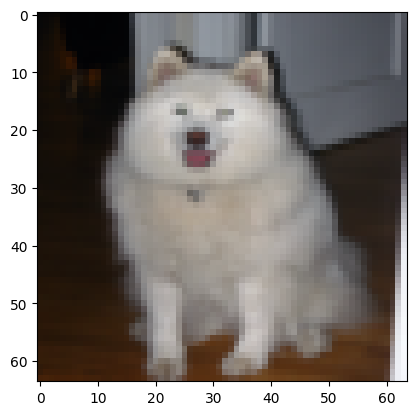

In [9]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

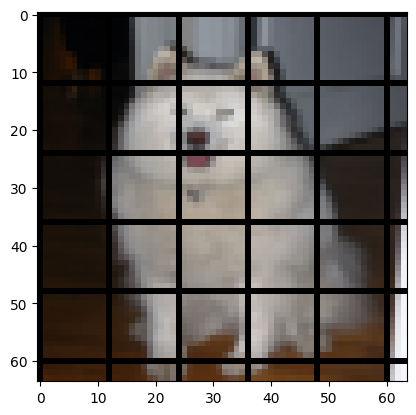

In [10]:
plt.imshow(draw_grid(train_dataset[0]["image"], 64//5))

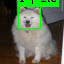

In [11]:

draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["label"])

In [27]:
train_dataset_ = Subset(train_dataset, range(0, 2))

In [28]:
import json

In [14]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment.json", "r"))
model = YOLO(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset_,
    num_epochs=100,
    lr=1e-3,
    batch_size=32,
    log_detections=False,
    lambda_coord=5.0,
    lambda_noobj=0.5,
    device="cpu",
    eval_every=100000,
)

In [14]:
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 39.84it/s, class_loss=4.07e-6, coord_loss=2.35e-6, loss=1.89e-5, noobj_loss=1.23e-5, obj_conf_loss=1.87e-7]    


[1.632457971572876,
 20.06002426147461,
 2.647526979446411,
 1.8535460233688354,
 26.46846580505371,
 2.5042715072631836,
 1.4573456048965454,
 3.1671640872955322,
 0.6238155961036682,
 0.2066849321126938,
 0.11522474884986877,
 0.21224431693553925,
 0.22345741093158722,
 0.18169328570365906,
 0.12502583861351013,
 0.06378965079784393,
 0.04923417046666145,
 0.07457324862480164,
 0.09289903938770294,
 0.0820247009396553,
 0.0557464063167572,
 0.042968664318323135,
 0.042784132063388824,
 0.03817969560623169,
 0.03259068727493286,
 0.02910226210951805,
 0.025405731052160263,
 0.023763030767440796,
 0.022967208176851273,
 0.02422153204679489,
 0.024978606030344963,
 0.018254689872264862,
 0.007856232114136219,
 0.005684695206582546,
 0.012145421467721462,
 0.016492336988449097,
 0.014201456680893898,
 0.009656093083322048,
 0.006544903852045536,
 0.005022149067372084,
 0.004786259960383177,
 0.006005529314279556,
 0.007109831552952528,
 0.006353746168315411,
 0.004384881351143122,
 0.003

In [15]:
count_model_parameters(model)

649340

In [29]:
dataloader = DataLoader(train_dataset_, batch_size=10, shuffle=False, collate_fn=collate_fn)
batch = next(iter(dataloader))

In [30]:
batch

{'images': tensor([[[[0.0275, 0.0275, 0.0275,  ..., 0.4588, 0.3333, 0.2627],
           [0.0275, 0.0314, 0.0314,  ..., 0.4588, 0.3333, 0.2627],
           [0.0275, 0.0314, 0.0353,  ..., 0.4549, 0.3255, 0.2667],
           ...,
           [0.2000, 0.2314, 0.2471,  ..., 0.9569, 0.9569, 0.9608],
           [0.2667, 0.2745, 0.2706,  ..., 0.9569, 0.9608, 0.9569],
           [0.2706, 0.2745, 0.2824,  ..., 0.9529, 0.9569, 0.9608]],
 
          [[0.0275, 0.0275, 0.0275,  ..., 0.4745, 0.3412, 0.2824],
           [0.0275, 0.0314, 0.0275,  ..., 0.4706, 0.3373, 0.2824],
           [0.0275, 0.0314, 0.0353,  ..., 0.4667, 0.3333, 0.2784],
           ...,
           [0.1059, 0.1216, 0.1176,  ..., 0.9647, 0.9686, 0.9686],
           [0.1294, 0.1294, 0.1294,  ..., 0.9647, 0.9647, 0.9647],
           [0.1333, 0.1333, 0.1373,  ..., 0.9608, 0.9647, 0.9647]],
 
          [[0.0275, 0.0275, 0.0235,  ..., 0.5098, 0.3765, 0.3137],
           [0.0275, 0.0275, 0.0235,  ..., 0.5098, 0.3686, 0.3137],
           [0.

In [31]:
i = 0

In [40]:
output = model.inference(
    batch["images"],
    confidence_threshold=0.5,
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.0540, 0.4858, 0.1602, 0.1254],
          [0.8174, 0.4177, 0.1943, 0.6896],
          [0.5871, 0.0167, 0.3508, 0.7902],
          [0.1309, 0.8158, 0.5784, 0.4210]]),
  'confidence': tensor([0.8428, 0.8149, 0.6741, 0.5526]),
  'labels': tensor([1, 0, 1, 0]),
  'scores': tensor([1.0000, 0.2138, 0.6743, 0.4891])},
 {'bboxes': tensor([[0.8148, 0.5218, 0.2797, 0.5464]]),
  'confidence': tensor([0.6117]),
  'labels': tensor([1]),
  'scores': tensor([0.1767])}]

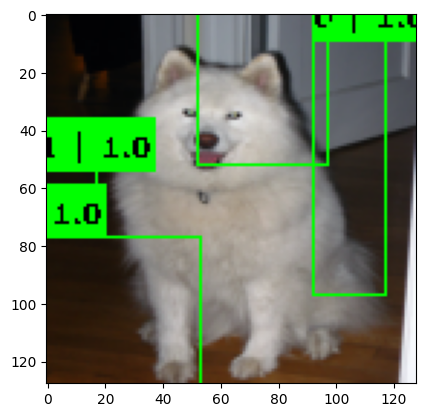

In [41]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

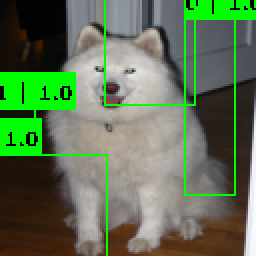

In [42]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [19]:
calculate_mAP(
    model,
    trainer.train_loader,
)

  0%|          | 0/1 [00:00<?, ?it/s]

{'map': 0.8999999761581421,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 0.8999999761581421,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.8999999761581421,
 'mar_10': 0.8999999761581421,
 'mar_100': 0.8999999761581421,
 'mar_small': 0.8999999761581421,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': 1}

In [325]:
torch.distributed.is_available()

True

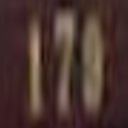

In [165]:
from PIL import Image
from torchvision.transforms import v2
image_path = "./examples/image (6).jpg"

G = 256
image = Image.open(image_path).resize((G, G))
image = v2.CenterCrop(128)(image)
image

In [169]:
G = 64

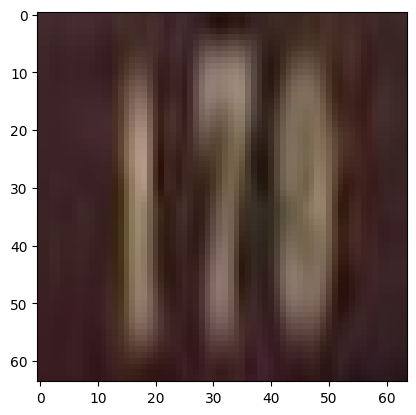

In [170]:
plt.imshow(image.resize((G, G), Image.LANCZOS))

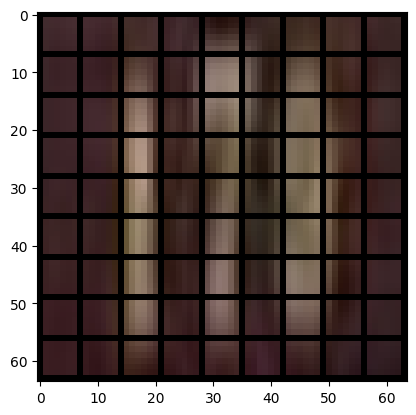

In [171]:
plt.imshow(draw_grid(image.resize((G, G)), G//9))

In [64]:
image.size

(76, 34)

In [18]:
import torchvision

d = torchvision.datasets.MNIST(root="./data/mnist", download=False, transform=v2.ToTensor())

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [19]:
loader = DataLoader(d, batch_size=64, shuffle=True)

In [21]:
for x in tqdm(loader):
    pass

100%|██████████| 938/938 [00:02<00:00, 458.41it/s]
